In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import random_split, DataLoader

# افزایش داده و نرمال سازی

In [3]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),

    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.44080), (0.2675, 0.2568, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.44080), (0.2675, 0.2568, 0.2761))
])

# بارگزاری داده ها

In [4]:
trainval_data = CIFAR100(root='./data', train=True, download=True,
                                              transform=transform_train)
test_data = CIFAR100(root='./data', train=False, download=True,
                      transform=transform_train)

Files already downloaded and verified
Files already downloaded and verified


# تقسیم داده به آموزش و اعتبار سنجی

In [5]:
train_size = int(0.6 * len(trainval_data))
val_size = len(trainval_data) - train_size
train_data, val_data = random_split(trainval_data, [train_size, val_size])


In [6]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# ساخت مدل CNN 

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


# آموزش مدل

In [11]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #L2 regularization
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

l1_lambda = 1e-5  # L1

train_losses, val_losses = [], []

for epoch in range(20):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # ارزیابی روی داده اعتبارسنجی
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


Epoch 1: Train Loss: 4.1626, Val Loss: 3.7503
Epoch 2: Train Loss: 3.7630, Val Loss: 3.5088
Epoch 3: Train Loss: 3.5626, Val Loss: 3.3020
Epoch 4: Train Loss: 3.4129, Val Loss: 3.1637
Epoch 5: Train Loss: 3.3008, Val Loss: 3.0475
Epoch 6: Train Loss: 3.2057, Val Loss: 2.9560
Epoch 7: Train Loss: 3.1210, Val Loss: 2.8879
Epoch 8: Train Loss: 3.0524, Val Loss: 2.8994
Epoch 9: Train Loss: 2.9907, Val Loss: 2.7595
Epoch 10: Train Loss: 2.9383, Val Loss: 2.7582
Epoch 11: Train Loss: 2.8779, Val Loss: 2.7183
Epoch 12: Train Loss: 2.8269, Val Loss: 2.5901
Epoch 13: Train Loss: 2.7869, Val Loss: 2.5313
Epoch 14: Train Loss: 2.7411, Val Loss: 2.5044
Epoch 15: Train Loss: 2.6855, Val Loss: 2.4541
Epoch 16: Train Loss: 2.6423, Val Loss: 2.5920
Epoch 17: Train Loss: 2.5883, Val Loss: 2.3653
Epoch 18: Train Loss: 2.5396, Val Loss: 2.3738
Epoch 19: Train Loss: 2.5058, Val Loss: 2.3582
Epoch 20: Train Loss: 2.4599, Val Loss: 2.2980


# ارزیابی مدل

              precision    recall  f1-score   support

           0     0.6637    0.7500    0.7042       100
           1     0.4340    0.4600    0.4466       100
           2     0.3291    0.2600    0.2905       100
           3     0.1556    0.0700    0.0966       100
           4     0.0508    0.0300    0.0377       100
           5     0.3103    0.2700    0.2888       100
           6     0.4592    0.4500    0.4545       100
           7     0.4722    0.3400    0.3953       100
           8     0.4904    0.5100    0.5000       100
           9     0.4359    0.5100    0.4700       100
          10     0.3729    0.2200    0.2767       100
          11     0.2155    0.3900    0.2776       100
          12     0.5778    0.2600    0.3586       100
          13     0.3797    0.3000    0.3352       100
          14     0.2674    0.2300    0.2473       100
          15     0.3113    0.3300    0.3204       100
          16     0.4884    0.4200    0.4516       100
          17     0.4184    

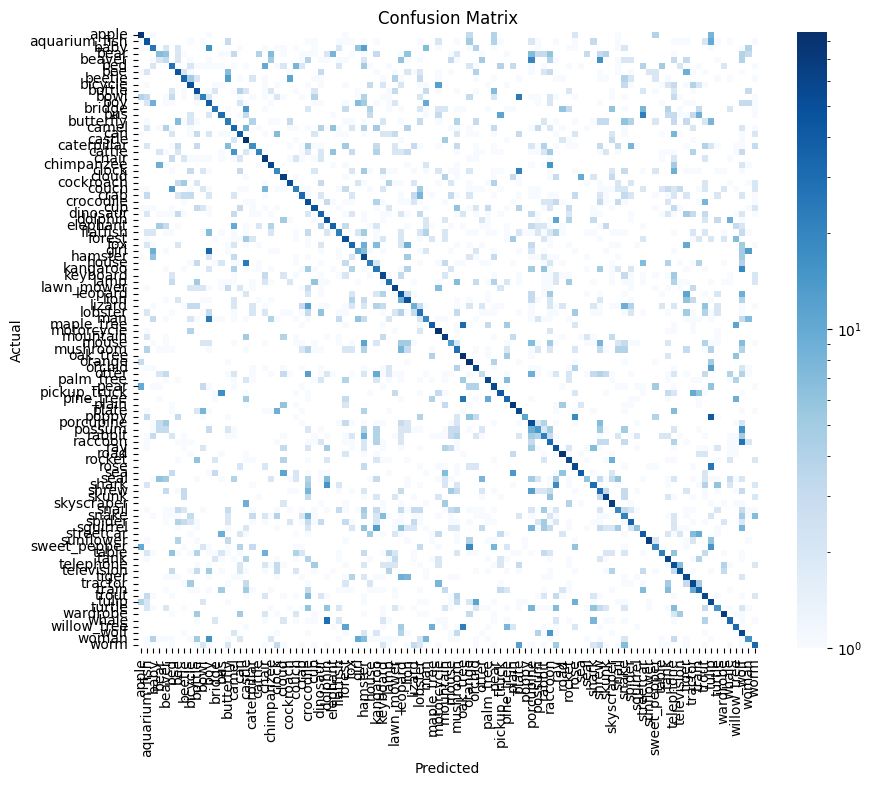

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# پیش‌بینی روی داده تست
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# متریک‌ها
print(classification_report(all_labels, all_preds, digits=4))

# ماتریس درهم‌ریختگی
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, xticklabels=test_data.classes, yticklabels=test_data.classes, cmap='Blues', norm='log')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [13]:
from torchvision import models

model_tl = models.resnet50(pretrained=True)
model_tl.fc = nn.Linear(model_tl.fc.in_features, 100)  # تطبیق با 100 کلاس

model_tl = model_tl.to(device)

optimizer = optim.Adam(model_tl.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# می‌توان لایه‌های اولیه را Freeze و فقط لایه‌های بالا را آموزش داد:
for param in model_tl.parameters():
    param.requires_grad = False
for param in model_tl.fc.parameters():
    param.requires_grad = True

c:\Users\Reza\anaconda3\envs\yolov8\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Reza\anaconda3\envs\yolov8\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


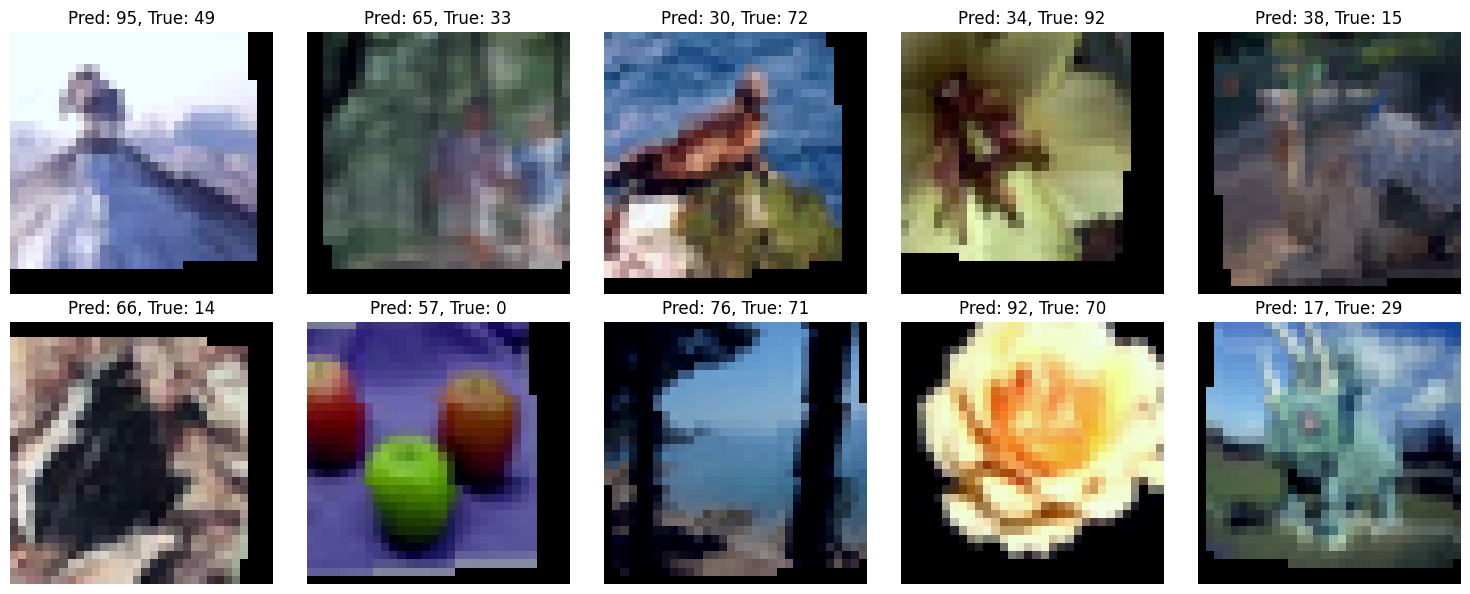

In [14]:
# نمایش 10 تصویر اشتباه پیش‌بینی‌شده
import matplotlib.pyplot as plt

misclassified = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                misclassified.append((inputs[i].cpu(), preds[i].item(), labels[i].item()))
        if len(misclassified) >= 10:
            break

# نمایش تصاویر
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, (img, pred, true) in enumerate(misclassified[:10]):
    img = img.permute(1, 2, 0).numpy()
    img = (img * 0.2761 + 0.4408).clip(0, 1)  # denormalize
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(f"Pred: {pred}, True: {true}")
    axs[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()